In [1]:
import sklearn
from pathlib import Path
import shutil
import pandas as pd

# %% Configurações de dataset
DATASET_NAME = 'mnist_784'
RANDOM_STATE = 1

# %% Carregamento
# X, y = sklearn.datasets.fetch_openml(data_id=554, return_X_y=True, as_frame=True)
# X, y = sklearn.datasets.load_digits(return_X_y=True, as_frame=True)

# # %% Split
# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
#     X, y, random_state=RANDOM_STATE, stratify=y
# )
caminho_treino = '../data/' + DATASET_NAME + '_train.csv'
caminho_teste = '../data/' + DATASET_NAME + '_test.csv'
X_train = pd.read_csv(caminho_treino)
X_test = pd.read_csv(caminho_teste)

y_train = X_train.pop('target')
y_test = X_test.pop('target')

# %% Diretórios temporários
TMP_ROOT = Path('../results/tmp') / DATASET_NAME
if TMP_ROOT.exists():
    shutil.rmtree(TMP_ROOT)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52500, 784), (17500, 784), (52500,), (17500,))

In [ ]:
from tpot import TPOTClassifier
from tpot import objectives
import time

def run_tpot(early_stop=20, max_time_mins=float('inf'), warm_start=False, search_space="linear"):
    scorer = sklearn.metrics.get_scorer('f1_weighted')

    tpot = TPOTClassifier(
        search_space=search_space,
        scorers=[scorer, objectives.complexity_scorer],
        scorers_weights=[1.0, -1.0],
        cv = 10,
        # memory= str(TMP_ROOT / 'memory'),
        preprocessing= True,
        max_time_mins=max_time_mins,
        max_eval_time_mins=10,
        n_jobs=4,
        validation_strategy='split',
        early_stop=early_stop,
        warm_start=warm_start,
        # periodic_checkpoint_folder= str(TMP_ROOT / 'checkpoints'),
        verbose=3,
        random_state=RANDOM_STATE,
        population_size=50,
    )
    start = time.time()
    tpot.fit(X_train, y_train)
    return tpot, time.time() - start

In [3]:
import os
import sys
from datetime import datetime
from sklearn.base import clone

sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

from metrics import evaluate_metrics
from serialize import serialize_tpot

def build_document(tpot, elapsed):
    """
    Gera um dicionário com métricas dos melhores modelos encontrados pelo TPOT.
    Mantém:
      - 'pareto_complexity': métricas do menor 'complexity_scorer' (desempate por maior 'f1_score')
      - 'pareto_f1': métricas do maior 'f1_score' (desempate por menor 'complexity_scorer')
      - 'best_model': métricas do tpot.fitted_pipeline_ 
    """

    individuals = tpot.evaluated_individuals
    individuals = individuals.drop(columns=individuals.select_dtypes(include="object").columns)
    individuals = individuals.drop(columns=["validation_f1_score", "validation_complexity_scorer", "validation_start_times", "validation_end_times"])
    individuals_dict = individuals.to_dict(orient='list')

    best_model = tpot.fitted_pipeline_
    model = serialize_tpot(best_model)
    metrics = evaluate_metrics(best_model, X_test, y_test)
    metrics['complexity_scorer'] = objectives.complexity_scorer(best_model, X_test, y_test)

    # Estrutura base do resultado
    result = {
        'timeStamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'time_spent': elapsed,
        'dataset': DATASET_NAME,
        'automl': 'tpot',
        'evaluated_individuals': individuals_dict,
        'models': {
            'fitted': model,
        },
        'metrics': {
            'fitted': metrics, 
        }   
    }
    
    # Verifica se existe Pareto front válido
    df = tpot.pareto_front
    if df is None or len(df) == 0:
        return result
    
    # Filtrar linhas válidas
    df_valid = df[
        df["Eval Error"].isna() &
        df["complexity_scorer"].notna() &
        df["f1_score"].notna() &
        df["Instance"].notna()
    ]
    
    if df_valid.empty:
        return result
    
    # Selecionar e treinar modelo de menor complexidade
    best_complexity = df_valid.sort_values(["complexity_scorer", "f1_score"], ascending=[True, False]).iloc[0]
    model = clone(best_complexity["Instance"])
    model.fit(X_train, y_train)
    result['models']['pareto_complexity'] = serialize_tpot(model)
    result['metrics']['pareto_complexity'] = evaluate_metrics(model, X_test, y_test)
    result['metrics']['pareto_complexity']['complexity_scorer'] = int(best_complexity["complexity_scorer"])
    
    # Selecionar e treinar modelo de maior F1
    best_f1 = df_valid.sort_values(["f1_score", "complexity_scorer"], ascending=[False, True]).iloc[0]
    model = clone(best_f1["Instance"])
    model.fit(X_train, y_train)
    result['models']['pareto_f1'] = serialize_tpot(model)
    result['metrics']['pareto_f1'] = evaluate_metrics(model, X_test, y_test)
    result['metrics']['pareto_f1']['complexity_scorer'] = int(best_f1["complexity_scorer"])
    
    return result, individuals

## Experimentos

In [4]:
tpot, elapsed = run_tpot(early_stop=5)

Generation: : 9it [22:39:51, 9269.63s/it]

Generation:  9
Best f1_score score: 0.9733516300199578
Best complexity_scorer score: 11.0


Generation: : 10it [25:39:49, 9741.34s/it]

Generation:  10
Best f1_score score: 0.9745806576778941
Best complexity_scorer score: 7.0


Generation: : 11it [28:33:49, 9955.35s/it]

Generation:  11
Best f1_score score: 0.9745806576778941
Best complexity_scorer score: 6.0


Generation: : 12it [31:45:43, 10429.55s/it]

Generation:  12
Best f1_score score: 0.9745806576778941
Best complexity_scorer score: 6.0


Generation: : 13it [35:32:50, 11397.94s/it]

Generation:  13
Best f1_score score: 0.9745806576778941
Best complexity_scorer score: 6.0


Generation: : 14it [37:58:32, 10595.90s/it]

Generation:  14
Best f1_score score: 0.9745806576778941
Best complexity_scorer score: 6.0


Generation: : 15it [40:48:06, 10468.66s/it]

Generation:  15
Best f1_score score: 0.9745806576778941
Best complexity_scorer score: 6.0


Generation: : 16it [43:00:09, 9702.34s/it] 

Generation:  16
Best f1_score score: 0.9745806576778941
Best complexity_scorer score: 6.0


Generation: : 16it [45:38:43, 10270.19s/it]

Generation:  17
Best f1_score score: 0.9745806576778941
Best complexity_scorer score: 6.0
Early stop



c:\Users\joaol\miniconda3\envs\tpotenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  52  53  54  55
  56  57  58  82  83  84  85 111 112 140 168 336 392 476 532 560 615 643
 644 671 672 673 699 700 701 727 728 729 730 753 754 755 756 757 758 759
 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\joaol\miniconda3\envs\tpotenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\joaol\miniconda3\envs\tpotenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [4]:
document, individuals = build_document(tpot, elapsed)

NameError: name 'build_document' is not defined

In [3]:
document

NameError: name 'document' is not defined

In [ ]:
individuals.head(5)

,f1_score,complexity_scorer,Generation,Submitted Timestamp,Completed Timestamp,Pareto_Front
0,NaN,NaN,0.0,1.755124e+09,1.755124e+09,NaN
1,NaN,NaN,0.0,1.755124e+09,1.755124e+09,NaN
2,NaN,NaN,0.0,1.755124e+09,1.755124e+09,NaN
3,NaN,NaN,0.0,1.755124e+09,1.755124e+09,NaN
4,0.754944,335758.0,0.0,1.755124e+09,1.755124e+09,NaN


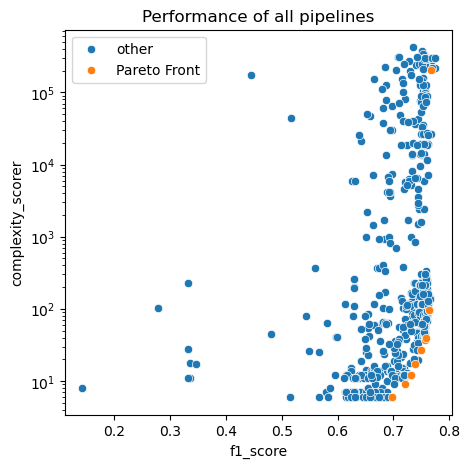

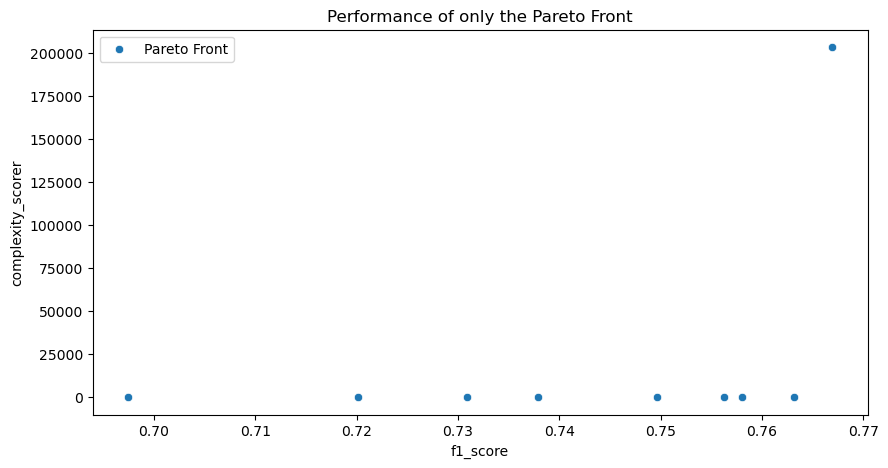

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = individuals
metric = 'f1_score'

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(df[df['Pareto_Front']!=1], x=metric, y='complexity_scorer', label='other', ax=ax)
sns.scatterplot(df[df['Pareto_Front']==1], x=metric, y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of all pipelines')
#log scale y
ax.set_yscale('log')
plt.show()

#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df[df['Pareto_Front']==1], x=metric, y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of only the Pareto Front')
#log scale y
# ax.set_yscale('log')
plt.show()

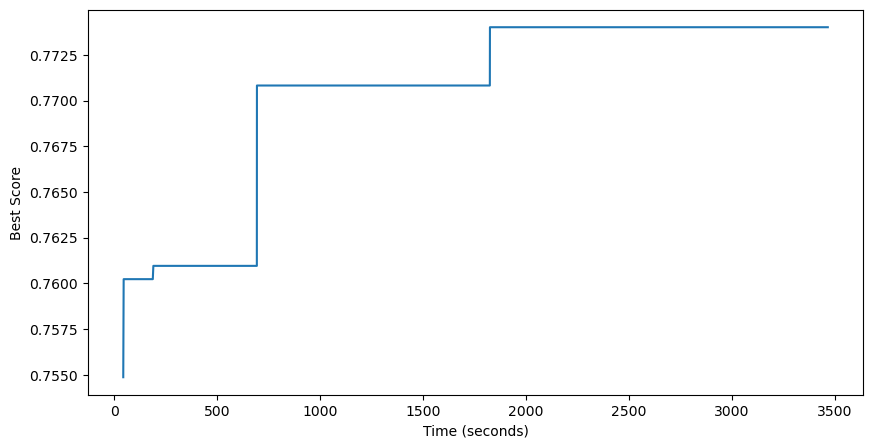

In [ ]:
import numpy as np

#get columns where roc_auc_score is not NaN
scores_and_times = df[df[metric].notna()][[metric, 'Completed Timestamp']].sort_values('Completed Timestamp', ascending=True).to_numpy()

#get best score at a given time
best_scores = np.maximum.accumulate(scores_and_times[:,0])
times = scores_and_times[:,1]
times = times - df['Submitted Timestamp'].min()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(times, best_scores)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Best Score')
plt.show()


In [ ]:
tpot.fitted_pipeline_

,steps,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('impute_numeric', ...)]"
,transform_input,None
,memory,None
,verbose,False
,columns,'all'
,missing_values,nan
,strategy,'mean'


In [ ]:
TMP_ROOT = Path('../results/tmp') / DATASET_NAME
if TMP_ROOT.exists():
    shutil.rmtree(TMP_ROOT)

# datasets do vertex:

- Breast Cancer (Escolhido)

- Imdb

- Mnist